<a href="https://colab.research.google.com/github/marathomas/meerkat/blob/master/08_meerkat_different_dataset_sizes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Test effect of different sample sizes

Dataset composition needs to remain constant. Maybe try with completely balanced set? Or is that already bad?

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pandas as pd
import sys
import librosa.display
import numpy as np
import statistics
import matplotlib.pyplot as plt
import glob
from pandas.core.common import flatten
import shutil
import pickle
import datetime
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.legend import Legend
from matplotlib.animation import FuncAnimation
from matplotlib import animation, rc, gridspec
import matplotlib
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import umap
from sklearn import metrics
from sklearn.metrics.pairwise import euclidean_distances
import umap
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors

PROJECT_PATH = "/content/drive/My Drive/meerkat/" 
FIGURES = PROJECT_PATH+"figures/"
DATA = PROJECT_PATH+"data/"

os.chdir(PROJECT_PATH)

In [ ]:
# Function that pads a spectrogram with zeros to a certain length
# Input: spectrogram (2D np array)
#        maximal length (Integer)
# Output: Padded spectrogram (2D np array)

def pad_spectro(spec,maxlen):
  padding = maxlen - spec.shape[1]
  z = np.zeros((spec.shape[0],padding))
  padded_spec=np.append(spec, z, axis=1)
  return padded_spec

def make_nn_stats_dict(calltypes, labels, indices):
  nn_stats_dict = {}

  for calltype in calltypes:
    call_indices = np.asarray(np.where(labels==calltype))[0]
    calltype_counts = np.zeros((call_indices.shape[0],len(calltypes)))

    for i,ind in enumerate(call_indices):
      nearest_neighbors = indices[ind]
      for neighbor in nearest_neighbors:
        neighbor_label = labels[neighbor]
        calltype_counts[i,np.where(np.asarray(calltypes)==neighbor_label)[0][0]] += 1 
    nn_stats_dict[calltype] = calltype_counts 
  
  return nn_stats_dict

def get_knn(k,embedding):

  # Scale
  scaler = MinMaxScaler(feature_range=(0,10))
  scaler.fit(embedding)
  embedding = scaler.transform(embedding)
  metric_type = 'euclidean'

  # Find k nearest neighbors
  nbrs = NearestNeighbors(metric='euclidean',n_neighbors=k+1, algorithm='brute').fit(embedding)
  distances, indices = nbrs.kneighbors(embedding)

  # need to remove the first neighbor, because that is the datapoint itself
  indices = indices[:,1:]  
  distances = distances[:,1:]

  return indices, distances


def make_statstabs(nn_stats_dict, calltypes, labels):
  # Overall frequencies
  overall = np.zeros((len(calltypes)))
  for i,calltype in enumerate(calltypes):
    overall[i] = sum(labels==calltype)

  overall = (overall/np.sum(overall))*100


  stats_tab = np.zeros((len(calltypes),len(calltypes)))
  stats_tab_norm = np.zeros((len(calltypes),len(calltypes)))

  for i, calltype in enumerate(calltypes):
    stats = nn_stats_dict[calltype]
    stats_tab[i,:] = (np.mean(stats,axis=0)/k)*100
    stats_tab_norm[i,:] = ((np.mean(stats,axis=0)/k)*100)/overall

  stats_tab = pd.DataFrame(stats_tab)
  stats_tab_norm = pd.DataFrame(stats_tab_norm)

  stats_tab.loc[len(stats_tab)] = overall
  #stats_tab_norm.loc[len(stats_tab_norm)] = overall/overall

  stats_tab.columns = calltypes
  stats_tab.index = calltypes+['overall']

  stats_tab_norm.columns = calltypes
  stats_tab_norm.index = calltypes

  x=stats_tab_norm.replace(0, 0.0001)
  stats_tab_norm = np.log2(x)

  #stats_tab_norm = np.log2(stats_tab_norm)

  return stats_tab, stats_tab_norm

In [ ]:
#df = pd.read_pickle(DATA+'df_denoised') # full
#df = pd.read_pickle(DATA+'df_denoised_less_cols') # full
df = pd.read_pickle(DATA+'df_denoised_balanced') # balanced
#df = pd.read_pickle(DATA+'embedding_denoised_stretched_mfcc_delta_balanced')
#df['index_id'] = df.index#

In [ ]:
spec_df = df[df.nonfocal_yn == 'n']
dftype='focal'
spec_df.shape

(6687, 35)

In [ ]:
spec_df = df

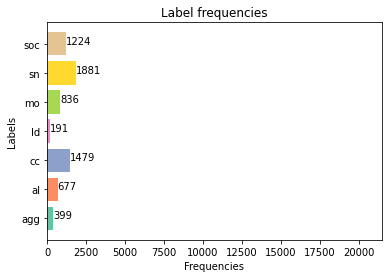

In [ ]:
labelcounts = pd.DataFrame(spec_df['call_lable'].value_counts())
labelcounts.sort_index(inplace=True)
pal = sns.color_palette("Set2", n_colors=len(labelcounts.index))
plt.barh(labelcounts.index, labelcounts.call_lable.values, color = pal)

for index, value in enumerate(labelcounts.call_lable.values):
    plt.text(value, index, str(value))

plt.title('Label frequencies')
plt.ylabel('Labels')
plt.xlabel('Frequencies')
plt.xlim(0,21500)
#plt.show()
plt.savefig(FIGURES+'final/'+'balanced_focal.png')

## Single

In [ ]:
# E) Completely balanced classes
labelcounts = pd.DataFrame(spec_df['call_lable'].value_counts())
class_size = np.min(labelcounts.call_lable.values)

subsets = []
for label, num in zip(labelcounts.index, labelcounts.call_lable.values):
  print(label, ":", num, ":", class_size/num)
  subsets.append(spec_df[spec_df.call_lable == label].sample(frac=(class_size/num), replace=False, random_state=1))

spec_df = pd.concat(subsets, axis=0)
dftype = 'complete_balanced'
pd.DataFrame(spec_df['call_lable'].value_counts())

sn : 1881 : 0.10154173312068049
cc : 1479 : 0.12914131169709264
soc : 1224 : 0.15604575163398693
mo : 836 : 0.2284688995215311
al : 677 : 0.2821270310192024
agg : 399 : 0.47869674185463656
ld : 191 : 1.0


,call_lable
agg,191
al,191
sn,191
soc,191
ld,191
cc,191
mo,191


In [ ]:
specs = spec_df.denoised_spectrograms.values # now 2D arrays n_mels+time_frames(varying)
method = 'denoised_melspectro'

In [ ]:
maxlen= np.max([spec.shape[1] for spec in specs])
flattened_specs = [pad_spectro(spec, maxlen).flatten() for spec in specs]
data = np.asarray(flattened_specs)

In [ ]:
reducer = umap.UMAP(low_memory=True, n_components = 5, min_dist=0, random_state=2204)
embedding = reducer.fit_transform(data)

In [ ]:
k=5
labels = spec_df.call_lable.values
calltypes = sorted(list(set(labels)))

indices, distances = get_knn(k,embedding)
nn_stats_dict = make_nn_stats_dict(calltypes, labels, indices)
stats_tab, stats_tab_norm = make_statstabs(nn_stats_dict, calltypes, labels)

print("Log final metric (unweighted):",np.mean(np.diagonal(stats_tab_norm)))
#print("Log Final metric (weighted):",round(np.average(np.diagonal(stats_tab_norm), weights=overall),2))
print("Abs final metric (unweighted):",round(np.mean(np.diagonal(stats_tab.iloc[:-1,])),2))
#print("Abs Final metric (weighted):",round(np.average(np.diagonal(stats_tab.iloc[:-1,]), weights=overall),2))

Log final metric (unweighted): 2.035047868517745
Abs final metric (unweighted): 59.54


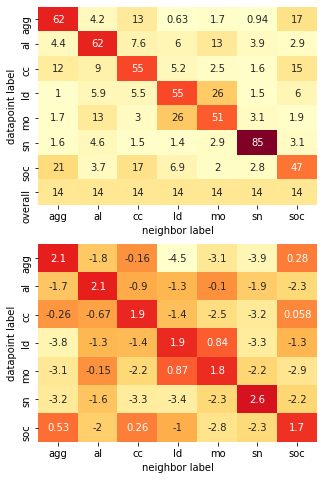

In [ ]:
plt.figure(figsize=(5,8))

plt.subplot(2, 1, 1)
ax=sns.heatmap(stats_tab, annot=True, cmap='YlOrRd', cbar=None)
plt.xlabel("neighbor label")
plt.ylabel("datapoint label")

plt.subplot(2, 1, 2)
ax=sns.heatmap(stats_tab_norm, center=0, annot=True, cmap='YlOrRd', cbar=None)
plt.xlabel("neighbor label")
plt.ylabel("datapoint label")

plt.savefig(FIGURES+'completely_balaneced_eval.png')



## Loop

In [ ]:
df_focal = df[df.nonfocal_yn == 'n']
k=5
class_sizes = [10,20,30,50,100,150,190]

n_class_table = np.zeros((len(class_sizes),2+7+7))

for i, class_size in enumerate(class_sizes):

  print('Processing N=',class_size)

  # subset spec_df
  labelcounts = pd.DataFrame(df_focal['call_lable'].value_counts())
  subsets = []
  for label in labelcounts.index:
    subsets.append(df_focal[df_focal.call_lable == label].sample(n=class_size, replace=False, random_state=2204))
  spec_df = pd.concat(subsets, axis=0)

  # UMAP
  specs = spec_df.denoised_spectrograms.values # now 2D arrays n_mels+time_frames(varying)
  method = 'denoised_melspectro'

  maxlen= np.max([spec.shape[1] for spec in specs])
  flattened_specs = [pad_spectro(spec, maxlen).flatten() for spec in specs]
  data = np.asarray(flattened_specs)

  reducer = umap.UMAP(low_memory=True, n_components = 5, min_dist=0, random_state=2204)
  embedding = reducer.fit_transform(data)

  # EVAL
  labels = spec_df.call_lable.values
  calltypes = sorted(list(set(labels)))

  indices, distances = get_knn(k,embedding)
  nn_stats_dict = make_nn_stats_dict(calltypes, labels, indices)
  stats_tab, stats_tab_norm = make_statstabs(nn_stats_dict, calltypes, labels)

  n_class_table[i,0] = np.mean(np.diagonal(stats_tab_norm))
  n_class_table[i,1] = np.mean(np.diagonal(stats_tab.iloc[:-1,]))

  n_class_table[i,2:9] = np.diagonal(stats_tab_norm)
  n_class_table[i,9:16] = np.diagonal(stats_tab)


  print("Snorm:",round(n_class_table[i,0],4))
  print("S:",round(n_class_table[i,1],4))

  # Plot
  #plt.figure(figsize=(5,8))

  #plt.subplot(2, 1, 1)
  #ax=sns.heatmap(stats_tab, annot=True, cmap='YlOrRd', cbar=None)
  #plt.xlabel("neighbor label")
  #plt.ylabel("datapoint label")

  #plt.subplot(2, 1, 2)
  #ax=sns.heatmap(stats_tab_norm, center=0, annot=True, cmap='YlOrRd', cbar=None)
  #plt.xlabel("neighbor label")
  #plt.ylabel("datapoint label")

  #plt.savefig(FIGURES+'completely_balaneced_'+str(class_size)+'N_eval.png')  


Processing N= 10
Snorm: 1.1095
S: 32.2857
Processing N= 20
Snorm: 1.393
S: 39.5714
Processing N= 30
Snorm: 1.6571
S: 47.2381
Processing N= 50
Snorm: 1.8478
S: 53.4286
Processing N= 100
Snorm: 1.9593
S: 56.8857
Processing N= 150
Snorm: 1.998
S: 58.4762
Processing N= 190
Snorm: 2.0499
S: 60.3008


In [ ]:
pd.DataFrame(n_class_table)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1.109506,32.285714,1.555816,0.622930,1.070389,1.333424,0.333424,1.687061,1.163499,42.000000,22.000000,30.000000,36.000000,18.000000,46.000000,32.000000
1,1.393026,39.571429,1.485427,0.970854,1.117695,1.748461,1.292782,2.272023,0.863938,40.000000,28.000000,31.000000,48.000000,35.000000,69.000000,26.000000
2,1.657058,47.238095,1.728283,1.787990,1.461179,1.644625,1.485427,2.521051,0.970854,47.333333,49.333333,39.333333,44.666667,40.000000,82.000000,28.000000
3,1.847848,53.428571,1.950095,1.991318,1.795767,1.929033,1.441483,2.576280,1.250962,55.200000,56.800000,49.600000,54.400000,38.800000,85.200000,34.000000
4,1.959349,56.885714,2.075190,2.065572,1.863938,1.885965,1.655352,2.579663,1.589763,60.200000,59.800000,52.000000,52.800000,45.000000,85.400000,43.000000
5,1.997964,58.476190,2.105231,2.166501,2.001442,1.874994,1.682873,2.589763,1.564947,61.466667,64.133333,57.200000,52.400000,45.866667,86.000000,42.266667
6,2.049910,60.300752,2.095480,2.175314,2.127460,1.872673,1.770440,2.591528,1.716471,61.052632,64.526316,62.421053,52.315789,48.736842,86.105263,46.947368


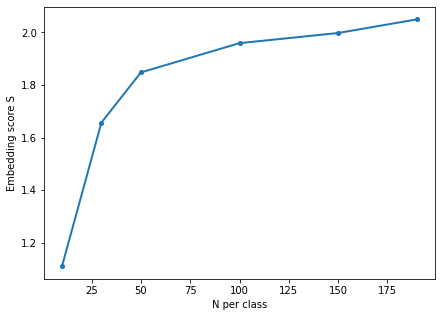

In [ ]:
fig = plt.figure(figsize= (7, 5))
plt.plot(class_sizes, n_class_table[:,0], marker='o',linewidth=2, markersize=4)
plt.ylabel("Embedding score S")
plt.xlabel("N per class")
#plt.show()
plt.savefig(FIGURES+'samplesizes_s.png')

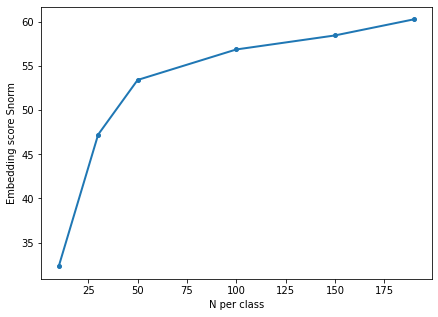

In [ ]:
fig = plt.figure(figsize= (7, 5))
plt.plot(class_sizes, n_class_table[:,1], marker='o',linewidth=2, markersize=4)
plt.ylabel("Embedding score Snorm")
plt.xlabel("N per class")
#plt.show()
plt.savefig(FIGURES+'samplesizes_snorm.png')

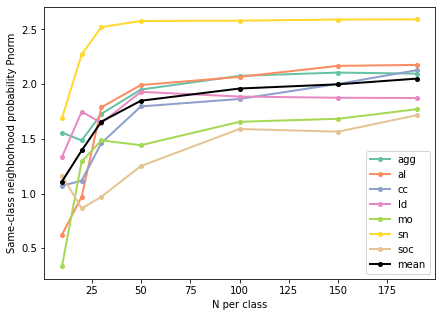

In [ ]:
fig = plt.figure(figsize= (7, 5))
sub_table = n_class_table[:,2:9]

pal = sns.color_palette("Set2", n_colors=len(calltypes))
color_dict = dict(zip(calltypes, pal))


for i,call_type in enumerate(calltypes):
  plt.plot(class_sizes, sub_table[:,i], marker='o',linewidth=2, markersize=4, color = color_dict[call_type],label=call_type)
plt.plot(class_sizes, n_class_table[:,0], marker='o',linewidth=2, markersize=4, color = 'black',label='mean')


plt.legend(loc='lower right')
#plt.ylabel("Embedding score Snorm")
plt.ylabel("Same-class neighborhood probability Pnorm")
plt.xlabel("N per class")
#plt.show()
plt.savefig(FIGURES+'samplesizes_snorm.png')

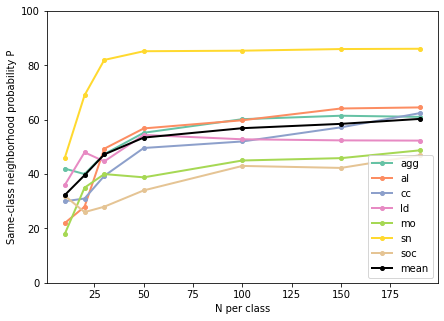

In [ ]:
fig = plt.figure(figsize= (7, 5))
sub_table = n_class_table[:,9:16]

pal = sns.color_palette("Set2", n_colors=len(calltypes))
color_dict = dict(zip(calltypes, pal))


for i,call_type in enumerate(calltypes):
  plt.plot(class_sizes, sub_table[:,i], marker='o',linewidth=2, markersize=4, color = color_dict[call_type],label=call_type)

plt.plot(class_sizes, n_class_table[:,1], marker='o',linewidth=2, markersize=4, color = 'black',label='mean')

plt.legend(loc='lower right')
#plt.ylabel("Embedding score S")
plt.ylabel("Same-class neighborhood probability P")
plt.ylim(0,100)
plt.xlabel("N per class")
#plt.show()
plt.savefig(FIGURES+'samplesizes_s.png')

# For imbalanced

In [ ]:
k=5
fracts = [0.05,0.1,0.2,0.3,0.5,0.75,1]
n_fract_table = np.zeros((len(fracts),2+7+7))

for i, fract in enumerate(fracts):

  print('Processing N=',fract)

  # subset spec_df
  subsets = []
  for label in labelcounts.index:
    subsets.append(df[df.call_lable == label].sample(frac=fract, replace=False, random_state=2204))
  spec_df = pd.concat(subsets, axis=0)

  # UMAP
  specs = spec_df.denoised_spectrograms.values # now 2D arrays n_mels+time_frames(varying)
  method = 'denoised_melspectro'

  maxlen= np.max([spec.shape[1] for spec in specs])
  flattened_specs = [pad_spectro(spec, maxlen).flatten() for spec in specs]
  data = np.asarray(flattened_specs)

  reducer = umap.UMAP(low_memory=True, n_components = 5, min_dist=0, random_state=2204)
  embedding = reducer.fit_transform(data)

  # EVAL
  labels = spec_df.call_lable.values
  calltypes = sorted(list(set(labels)))

  indices, distances = get_knn(k,embedding)
  nn_stats_dict = make_nn_stats_dict(calltypes, labels, indices)
  stats_tab, stats_tab_norm = make_statstabs(nn_stats_dict, calltypes, labels)

  n_fract_table[i,0] = np.mean(np.diagonal(stats_tab_norm))
  n_fract_table[i,1] = np.mean(np.diagonal(stats_tab.iloc[:-1,]))

  n_fract_table[i,2:9] = np.diagonal(stats_tab_norm)
  n_fract_table[i,9:16] = np.diagonal(stats_tab)

  print("Snorm:",round(n_fract_table[i,0],4))
  print("S:",round(n_fract_table[i,1],4))

  # Plot
  #plt.figure(figsize=(5,8))

  #plt.subplot(2, 1, 1)
  #ax=sns.heatmap(stats_tab, annot=True, cmap='YlOrRd', cbar=None)
  #plt.xlabel("neighbor label")
  #plt.ylabel("datapoint label")

  #plt.subplot(2, 1, 2)
  #ax=sns.heatmap(stats_tab_norm, center=0, annot=True, cmap='YlOrRd', cbar=None)
  #plt.xlabel("neighbor label")
  #plt.ylabel("datapoint label")

  #plt.savefig(FIGURES+'completely_balaneced_'+str(fract)+'fr_eval.png')  


Processing N= 0.05
Snorm: 1.8629
S: 48.5712
Processing N= 0.1
Snorm: 1.904
S: 50.5325
Processing N= 0.2
Snorm: 2.0832
S: 52.1406
Processing N= 0.3
Snorm: 2.1222
S: 52.9441
Processing N= 0.5
Snorm: 2.2054
S: 54.5972
Processing N= 0.75
Snorm: 2.2703
S: 56.3001
Processing N= 1
Snorm: 2.3796
S: 58.1751


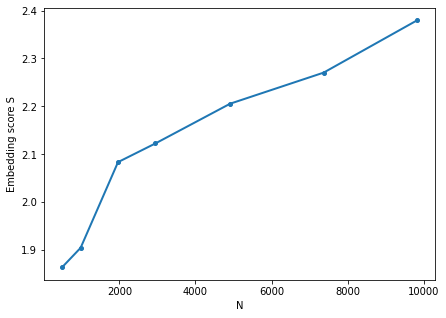

In [ ]:
fig = plt.figure(figsize= (7, 5))
x = [fract*df.shape[0] for fract in fracts]
plt.plot(x, n_fract_table[:,0], marker='o',linewidth=2, markersize=4)
plt.ylabel("Embedding score S")
plt.xlabel("N")
plt.show()
#plt.savefig(FIGURES+'samplesizes_s.png')

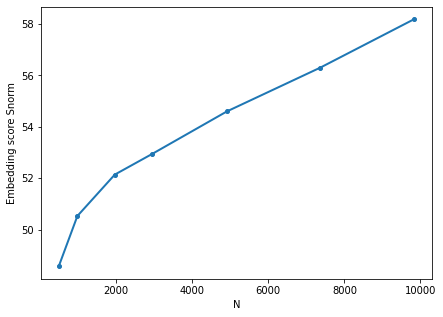

In [ ]:
fig = plt.figure(figsize= (7, 5))
x = [fract*df.shape[0] for fract in fracts]
plt.plot(x, n_fract_table[:,1], marker='o',linewidth=2, markersize=4)
plt.ylabel("Embedding score Snorm")
plt.xlabel("N")
plt.show()

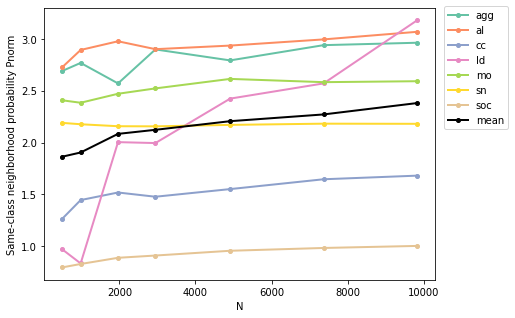

In [99]:
fig = plt.figure(figsize= (7, 5))
sub_table = n_fract_table[:,2:9]

pal = sns.color_palette("Set2", n_colors=len(calltypes))
color_dict = dict(zip(calltypes, pal))

x = [fract*df.shape[0] for fract in fracts]

for i,call_type in enumerate(calltypes):
  plt.plot(x, sub_table[:,i], marker='o',linewidth=2, markersize=4, color = color_dict[call_type],label=call_type)
plt.plot(x, n_fract_table[:,0], marker='o',linewidth=2, markersize=4, color = 'black',label='mean')

#plt.legend(loc='lower right')
#plt.xlim(0,13000)

lgd = plt.legend(bbox_to_anchor=(1.2, 0.78), loc='right')

#plt.ylabel("Embedding score Snorm")
plt.ylabel("Same-class neighborhood probability Pnorm")
plt.xlabel("N")
#plt.show()
#plt.savefig(FIGURES+'samplesizes_imbalanced_snorm.png')
plt.savefig(FIGURES+'samplesizes_imbalanced_snorm.png', bbox_extra_artists=(lgd,), bbox_inches='tight')

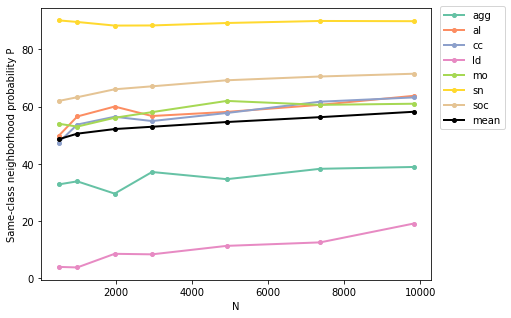

In [98]:
fig = plt.figure(figsize= (7, 5))
sub_table = n_fract_table[:,9:16]

pal = sns.color_palette("Set2", n_colors=len(calltypes))
color_dict = dict(zip(calltypes, pal))

x = [fract*df.shape[0] for fract in fracts]

for i,call_type in enumerate(calltypes):
  plt.plot(x, sub_table[:,i], marker='o',linewidth=2, markersize=4, color = color_dict[call_type],label=call_type)
plt.plot(x, n_fract_table[:,1], marker='o',linewidth=2, markersize=4, color = 'black',label='mean')

#plt.legend(loc='lower right')

lgd = plt.legend(bbox_to_anchor=(1.2, 0.78), loc='right')

#plt.xlim(0,13000)
#plt.ylabel("Embedding score S")
plt.ylabel("Same-class neighborhood probability P")
plt.xlabel("N")
#plt.show()
plt.savefig(FIGURES+'samplesizes_imbalanced_s.png', bbox_extra_artists=(lgd,), bbox_inches='tight')

#plt.savefig(FIGURES+'samplesizes_imbalanced_s.png')